In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# فصل ۵ — درخت‌های تصمیم و گونه‌ها
## درس ۵: درخت‌های تصمیم C4.5 و C5.0



### جایگاه درس در دوره

این نوت‌بوک بخشی از **دوره‌ی مقدماتی یادگیری ماشین** (۳۷ فصل) است.  
شما اکنون در **فصل ۵: درخت‌های تصمیم و گونه‌ها** و **درس ۵: درخت‌های تصمیم C4.5 و C5.0** هستید.

> نکته‌ی نام‌گذاری فایل: طبق قراردادی که برای مخزن مشخص کرده‌اید، فایل‌ها با نام `Chapter5_Lesson4(.ipynb/_Fa.ipynb)` ذخیره شده‌اند، حتی با اینکه موضوع اینجا «درس ۵» است.

---

## چرا این درس مهم است؟

حتی اگر قصد دارید از ensembleهای مدرن درختی (Random Forest و Gradient Boosting) استفاده کنید، فهم C4.5/C5.0 ارزشمند است چون:

- به شما یاد می‌دهد معیارهای آنتروپی‌محور چگونه و چرا رفتار می‌کنند،
- دام‌های ویژگی‌های طبقه‌ای (به‌خصوص high-cardinality) را برجسته می‌کند،
- هرس را به تعمیم‌پذیری و کنترل ظرفیت وصل می‌کند،
- یک دید تفسیرپذیر ارائه می‌دهد: درخت → قوانین → ممیزی‌پذیری.

---

## اهداف یادگیری

در پایان باید بتوانید:

1. **C4.5** را نسبت به **ID3** و **CART** توضیح دهید.
2. آنتروپی، اطلاعاتِ بهره، SplitInfo و **Gain Ratio** را محاسبه کنید.
3. توضیح دهید C4.5 ویژگی‌های **پیوسته** را با آستانه‌گذاری مدیریت می‌کند.
4. مفهوم هرس را توضیح دهید و یک روش هرس را نمایش دهید.
5. بهبودهای اصلی **C5.0** (سرعت، بوستینگ، Winnowing/قوانین) را بیان کنید.
6. یک گردش‌کار کامل را روی چند دیتاست مخزن خودتان با مسیرهای نسبی اجرا کنید.

---

## نقشه مفهومی

درخت‌های تصمیم در تقاطعِ این حوزه‌ها قرار می‌گیرند:

- **بهینه‌سازی** (جست‌وجوی حریصانه تقسیم),
- **نظریه اطلاعات** (آنتروپی و اطلاعاتِ بهره),
- **آمار** (تعمیم‌پذیری در برابر بیش‌برازش),
- **مهندسی نرم‌افزار** (مدیریت گمشده، کدگذاری طبقه‌ای، pipeline بازتولیدپذیر).

ما ریاضیات را سبک ولی دقیق نگه می‌داریم و هر مفهوم را با کد قابل اجرا همراه می‌کنیم.



## فرمول‌های اصلی (با $...$ و $$...$$)

### آنتروپی

اگر در دیتاست $S$ احتمال‌های تجربی کلاس‌ها $p_k$ باشد:

$$
H(S) = -\sum_{k=1}^K p_k \log_2(p_k)
$$

تفسیر:

- اگر $H(S)=0$ باشد، گره خالص است.
- آنتروپی بیشتر یعنی عدم‌قطعیت/اختلاط بیشتر.

### اطلاعاتِ بهره (ID3)

اگر ویژگی $A$ داده را به $S_1,\dots,S_m$ تقسیم کند:

$$
IG(S,A) = H(S) - \sum_{i=1}^m \frac{|S_i|}{|S|} H(S_i)
$$

مشکل: ویژگی‌های با مقدارهای زیاد می‌توانند با خردکردن داده، $IG$ را مصنوعی بزرگ کنند.

### SplitInfo و Gain Ratio (در C4.5)

$$
SplitInfo(S,A) = -\sum_{i=1}^m \frac{|S_i|}{|S|} \log_2\left(\frac{|S_i|}{|S|}\right)
$$

$$
GainRatio(S,A) = \frac{IG(S,A)}{SplitInfo(S,A)}
$$

شهود: Gain Ratio تقسیم‌های بسیار خردشده را جریمه می‌کند (کنترل سوگیری high-cardinality).

### ویژگی‌های پیوسته

برای ویژگی عددی $x$ آستانه‌های $t$ بررسی می‌شود:

$$
x \le t \quad \text{در برابر} \quad x > t
$$

آستانه‌های کاندید معمولاً نقطه میانی بین مقدارهای یکتای مرتب‌شده هستند (یا کاراتر: فقط جایی که کلاس تغییر می‌کند).



## بارگذاری دیتاست‌ها (چند دیتاست، مسیر نسبی)

سه دیتاست را از پوشه `Datasets/Classification/` با مسیرهای نسبی بارگذاری می‌کنیم، مانند:

- `../../../Datasets/Classification/iris.csv`

این کار گردش‌کار شما را قابل استفاده مجدد می‌کند و به مسیرهای مطلق وابسته نمی‌مانید.

سل کد بعدی را اجرا کنید تا کتابخانه‌ها وارد شوند و دیتاست‌ها به‌صورت تصادفی (اما با seed ثابت) انتخاب شوند.
سپس سل بعدی را اجرا کنید تا داده‌ها بارگذاری شوند و چند ردیف اول و توزیع برچسب‌ها نمایش داده شود.


In [2]:
# Core stack
import numpy as np
import pandas as pd
from pathlib import Path

# Plotting (keep titles/labels in English for both notebooks as requested)
import matplotlib.pyplot as plt

# Scikit-learn for baselines and evaluation (CART baseline and boosting demo)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier

np.random.seed(42)

def safe_read_csv(rel_path: str, **kwargs) -> pd.DataFrame:
    '''
    Read a CSV using the repository-relative path. If the file is missing, raise a friendly error.
    '''
    p = Path(rel_path)
    if not p.exists():
        raise FileNotFoundError(
            f"Dataset not found at: {rel_path}\n"
            "Make sure you are running this notebook from:\n"
            "Tutorials/English/Chapter5/   (or Tutorials/Persian/Chapter5/)\n"
            "and that the repo has the Datasets/ folder at the root."
        )
    return pd.read_csv(p, **kwargs)

def describe_df(df: pd.DataFrame, name: str, target: str = None):
    print(f"=== {name} ===")
    print("Shape:", df.shape)
    print("\nHead:")
    display(df.head())
    print("\nDtypes:")
    display(df.dtypes.to_frame("dtype").T)
    if target is not None and target in df.columns:
        print("\nTarget distribution:")
        display(df[target].value_counts(dropna=False).to_frame("count").T)

# Choose multiple datasets "randomly" but deterministically (seed fixed above)
DATASET_POOL = [
    ("Iris", "../../../Datasets/Classification/iris.csv", "classification"),
    ("Diabetes", "../../../Datasets/Classification/diabetes.csv", "classification"),
    ("Drug200", "../../../Datasets/Classification/drug200.csv", "Drug"),
    ("Wine_Quality", "../../../Datasets/Classification/Wine_Quality.csv", "quality"),
    ("Glass", "../../../Datasets/Classification/glass.csv", "Type"),
]

picked = list(np.random.choice(len(DATASET_POOL), size=3, replace=False))
CHOSEN = [DATASET_POOL[i] for i in picked]
CHOSEN


[('Diabetes',
  '../../../Datasets/Classification/diabetes.csv',
  'classification'),
 ('Glass', '../../../Datasets/Classification/glass.csv', 'Type'),
 ('Drug200', '../../../Datasets/Classification/drug200.csv', 'Drug')]

In [3]:
datasets = {}
for name, path, target in CHOSEN:
    df = safe_read_csv(path)
    datasets[name] = {"df": df, "target": target, "path": path}

for name, meta in datasets.items():
    describe_df(meta["df"], name=name, target=meta["target"])


=== Diabetes ===
Shape: (768, 9)

Head:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic



Dtypes:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
dtype,int64,int64,int64,int64,int64,float64,float64,int64,object



Target distribution:


classification,Non-Diabetic,Diabetic
count,500,268


=== Glass ===
Shape: (214, 10)

Head:


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,building_windows_float_processed
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,building_windows_float_processed
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,building_windows_float_processed
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,building_windows_float_processed
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,building_windows_float_processed



Dtypes:


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,object



Target distribution:


Type,building_windows_non_float_processed,building_windows_float_processed,headlamps,vehicle_windows_float_processed,containers,tableware
count,76,70,29,17,13,9


=== Drug200 ===
Shape: (200, 6)

Head:


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY



Dtypes:


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
dtype,int64,object,object,object,float64,object



Target distribution:


Drug,DrugY,drugX,drugA,drugC,drugB
count,91,54,23,16,16



## EDA سریع (بررسی‌های اولیه)

قبل از مدل‌سازی چند بررسی انجام دهید:

- ستون‌های عددی vs طبقه‌ای،
- مقادیر گمشده،
- عدم‌تعادل برچسب‌ها،
- ستون‌های مشکوک به نشت (IDها، زمان‌هایی که برچسب را رمزگذاری می‌کنند).

درخت‌ها نشت را خیلی سریع استفاده می‌کنند و دقت را مصنوعی بالا می‌برند؛ این بررسی‌ها جلوی نتیجه‌گیری غلط را می‌گیرد.

ما برای ویژگی‌های عددی دیتاست اول هیستوگرام رسم می‌کنیم.


In [4]:
def plot_numeric_histograms(df: pd.DataFrame, cols, title_prefix: str = ""):
    cols = list(cols)
    n = len(cols)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3.5*nrows))
    axes = np.array(axes).reshape(-1)
    for ax, c in zip(axes, cols):
        ax.hist(df[c].dropna().values, bins=25)
        ax.set_title(f"{title_prefix}{c}")
        ax.set_xlabel(c)
        ax.set_ylabel("count")
    for ax in axes[len(cols):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


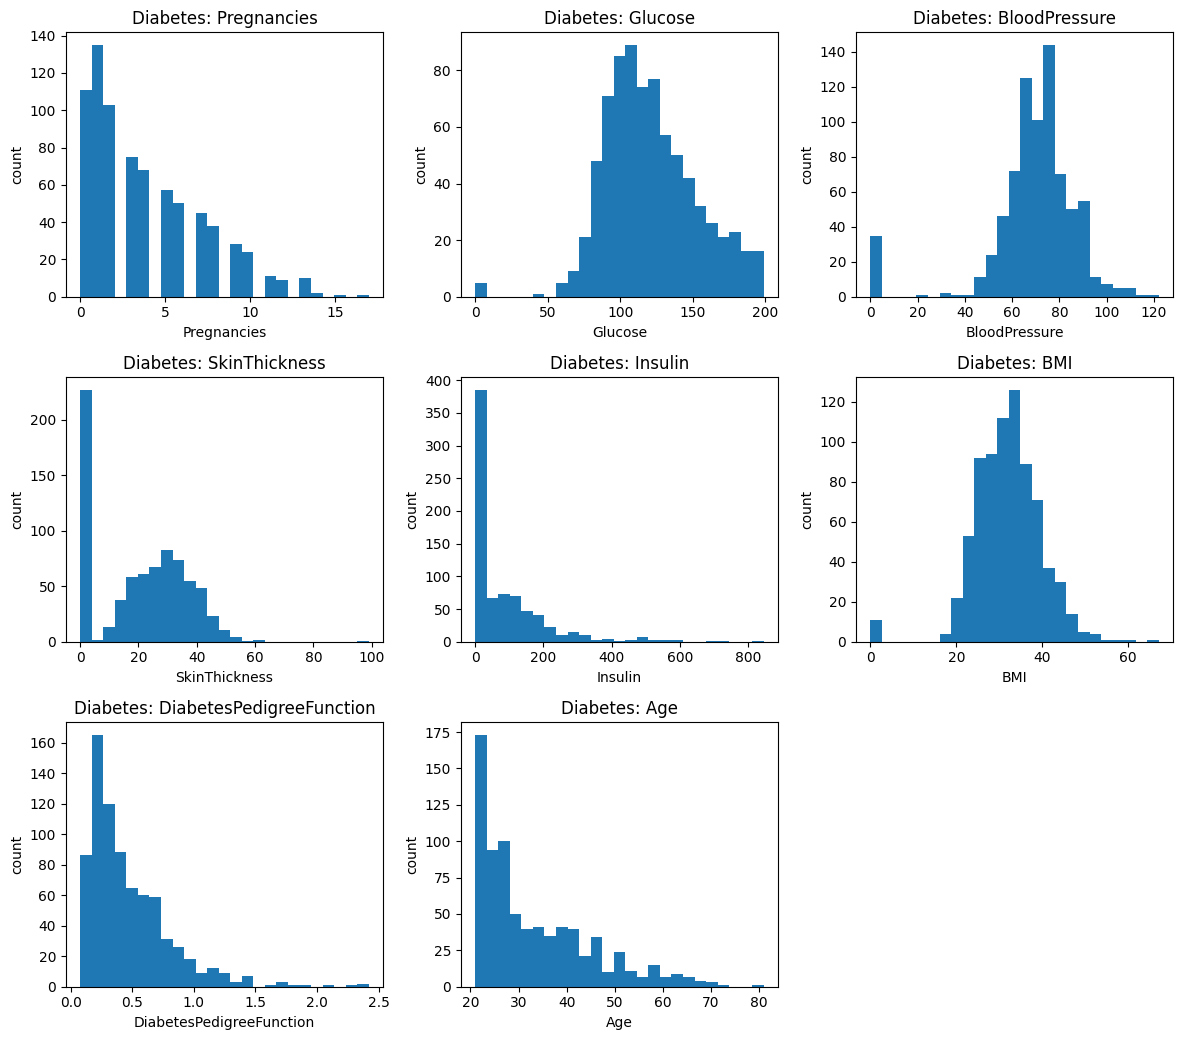

In [5]:
# Plot numeric histograms for the first chosen dataset
name0 = CHOSEN[0][0]
df0 = datasets[name0]["df"]
target0 = datasets[name0]["target"]
num_cols0 = [c for c in df0.columns if c != target0 and pd.api.types.is_numeric_dtype(df0[c])]
if len(num_cols0) > 0:
    plot_numeric_histograms(df0, num_cols0[:12], title_prefix=f"{name0}: ")
else:
    print("No numeric columns to plot for the first dataset.")



## پیاده‌سازی درخت شبه C4.5

یک نسخه‌ی آموزشی و حداقلی از C4.5 را پیاده‌سازی می‌کنیم:

- معیار: Gain Ratio
- تقسیم‌ها:
  - طبقه‌ای: چندشاخه‌ای (یک شاخه برای هر دسته)
  - عددی: دودویی با آستانه
- توقف: max_depth، min_samples_split و خلوص
- مقادیر گمشده: ساده (میانه/مقدار ویژه)

این نسخه تولیدی نیست، اما ایده‌های اصلی را منتقل می‌کند.

سل بعد را برای تعریف پیاده‌سازی اجرا کنید.


In [6]:
from dataclasses import dataclass
from typing import Any, Dict, Optional, Tuple, List

def entropy(y: pd.Series) -> float:
    y = y.dropna()
    if len(y) == 0:
        return 0.0
    p = y.value_counts(normalize=True)
    return float(-(p * np.log2(p)).sum())

def split_info(groups: List[pd.Series], n_total: int) -> float:
    sizes = np.array([len(g) for g in groups], dtype=float)
    sizes = sizes[sizes > 0]
    if len(sizes) == 0:
        return 0.0
    p = sizes / n_total
    return float(-(p * np.log2(p)).sum())

def information_gain(y: pd.Series, groups: List[pd.Series]) -> float:
    n_total = len(y)
    base = entropy(y)
    rem = 0.0
    for g in groups:
        if len(g) == 0:
            continue
        rem += (len(g)/n_total) * entropy(g)
    return base - rem

def gain_ratio(y: pd.Series, groups: List[pd.Series]) -> float:
    ig = information_gain(y, groups)
    si = split_info(groups, len(y))
    if si <= 1e-12:
        return 0.0
    return ig / si

@dataclass
class Node:
    is_leaf: bool
    prediction: Any = None
    feature: Optional[str] = None
    threshold: Optional[float] = None
    children: Optional[Dict[Any, "Node"]] = None
    left: Optional["Node"] = None
    right: Optional["Node"] = None
    n_samples: int = 0
    class_counts: Optional[Dict[Any, int]] = None

def majority_class(y: pd.Series):
    vc = y.value_counts(dropna=False)
    return vc.index[0]

def best_split_for_numeric(X_col: pd.Series, y: pd.Series) -> Tuple[float, float]:
    df = pd.DataFrame({"x": X_col, "y": y}).dropna()
    if df["x"].nunique() <= 1:
        return 0.0, None
    df = df.sort_values("x")
    uniq = np.unique(df["x"].values)
    thresholds = (uniq[:-1] + uniq[1:]) / 2.0
    best_gr, best_t = 0.0, None
    for t in thresholds:
        left_y = df.loc[df["x"] <= t, "y"]
        right_y = df.loc[df["x"] > t, "y"]
        gr = gain_ratio(df["y"], [left_y, right_y])
        if gr > best_gr:
            best_gr, best_t = gr, float(t)
    return best_gr, best_t

def best_split_for_categorical(X_col: pd.Series, y: pd.Series) -> float:
    df = pd.DataFrame({"x": X_col, "y": y}).dropna()
    if df["x"].nunique() <= 1:
        return 0.0
    groups = [df.loc[df["x"] == v, "y"] for v in df["x"].unique()]
    return gain_ratio(df["y"], groups)

def find_best_split(X: pd.DataFrame, y: pd.Series, feature_types: Dict[str, str]):
    best = {"gain_ratio": 0.0, "feature": None, "type": None, "threshold": None}
    for col in X.columns:
        if feature_types[col] == "numeric":
            gr, t = best_split_for_numeric(X[col], y)
            if t is not None and gr > best["gain_ratio"]:
                best = {"gain_ratio": gr, "feature": col, "type": "numeric", "threshold": t}
        else:
            gr = best_split_for_categorical(X[col], y)
            if gr > best["gain_ratio"]:
                best = {"gain_ratio": gr, "feature": col, "type": "categorical", "threshold": None}
    return best

def infer_feature_types(df: pd.DataFrame, target: str) -> Dict[str, str]:
    types = {}
    for c in df.columns:
        if c == target:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            types[c] = "numeric"
        else:
            types[c] = "categorical"
    return types

def build_tree(df: pd.DataFrame, target: str, max_depth: int = 6, min_samples_split: int = 10, depth: int = 0) -> Node:
    y = df[target]
    node = Node(is_leaf=False, n_samples=len(df), class_counts=y.value_counts().to_dict())
    # Stopping
    if y.nunique(dropna=False) <= 1:
        node.is_leaf = True
        node.prediction = y.dropna().iloc[0] if len(y.dropna()) else None
        return node
    if depth >= max_depth or len(df) < min_samples_split:
        node.is_leaf = True
        node.prediction = majority_class(y)
        return node

    X = df.drop(columns=[target])
    feature_types = infer_feature_types(df, target)
    best = find_best_split(X, y, feature_types)

    if best["feature"] is None or best["gain_ratio"] <= 1e-12:
        node.is_leaf = True
        node.prediction = majority_class(y)
        return node

    node.feature = best["feature"]

    if best["type"] == "numeric":
        node.threshold = best["threshold"]
        left_df = df[df[node.feature] <= node.threshold]
        right_df = df[df[node.feature] > node.threshold]
        if len(left_df) == 0 or len(right_df) == 0:
            node.is_leaf = True
            node.prediction = majority_class(y)
            node.feature = None
            node.threshold = None
            return node
        node.left = build_tree(left_df, target, max_depth=max_depth, min_samples_split=min_samples_split, depth=depth+1)
        node.right = build_tree(right_df, target, max_depth=max_depth, min_samples_split=min_samples_split, depth=depth+1)
    else:
        node.children = {}
        for v in df[node.feature].dropna().unique():
            sub = df[df[node.feature] == v]
            node.children[v] = build_tree(sub, target, max_depth=max_depth, min_samples_split=min_samples_split, depth=depth+1)

    node.prediction = majority_class(y)  # default for unseen branches
    return node

def predict_one(node: Node, row: pd.Series):
    while not node.is_leaf:
        if node.feature is None:
            break
        if node.threshold is not None:
            x = row.get(node.feature, np.nan)
            if pd.isna(x):
                return node.prediction
            node = node.left if x <= node.threshold else node.right
            if node is None:
                return None
        else:
            x = row.get(node.feature, np.nan)
            if pd.isna(x):
                return node.prediction
            if node.children is None:
                return node.prediction
            node = node.children.get(x, None)
            if node is None:
                return None
    return node.prediction

def predict(node: Node, X: pd.DataFrame):
    return X.apply(lambda r: predict_one(node, r), axis=1)

def tree_depth(node: Node) -> int:
    if node is None:
        return 0
    if node.is_leaf:
        return 1
    if node.threshold is not None:
        return 1 + max(tree_depth(node.left), tree_depth(node.right))
    if node.children:
        return 1 + max(tree_depth(ch) for ch in node.children.values())
    return 1

def count_nodes(node: Node) -> int:
    if node is None:
        return 0
    if node.is_leaf:
        return 1
    if node.threshold is not None:
        return 1 + count_nodes(node.left) + count_nodes(node.right)
    if node.children:
        return 1 + sum(count_nodes(ch) for ch in node.children.values())
    return 1



## آموزش و ارزیابی درخت Gain Ratio

روی دیتاست اول آموزش می‌دهیم و گزارش می‌کنیم:

- accuracy،
- ماتریس اغتشاش،
- گزارش طبقه‌بندی.

سل بعد را اجرا کنید.


Dataset: Diabetes | target: classification
Custom C4.5-ish tree accuracy: 0.7083333333333334
Tree depth: 8 | nodes: 27


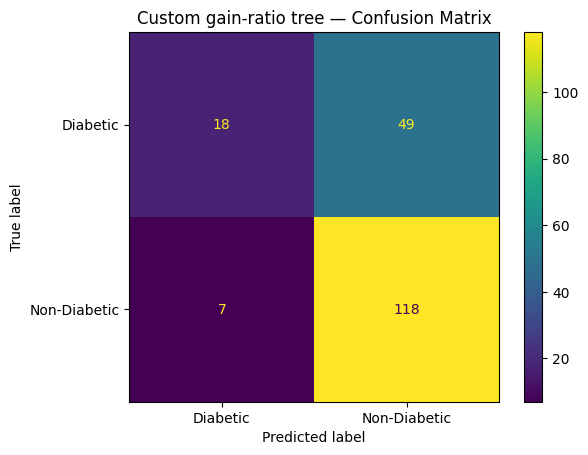


Classification report:
              precision    recall  f1-score   support

    Diabetic       0.72      0.27      0.39        67
Non-Diabetic       0.71      0.94      0.81       125

    accuracy                           0.71       192
   macro avg       0.71      0.61      0.60       192
weighted avg       0.71      0.71      0.66       192



In [7]:
def train_eval_custom_c45(df: pd.DataFrame, target: str, test_size: float = 0.25, max_depth: int = 6):
    # Simple missing value handling:
    # - numeric: median imputation
    # - categorical: fill with a sentinel string
    work = df.copy()
    for c in work.columns:
        if c == target:
            continue
        if pd.api.types.is_numeric_dtype(work[c]):
            work[c] = work[c].fillna(work[c].median())
        else:
            work[c] = work[c].fillna("__MISSING__")

    train_df, test_df = train_test_split(work, test_size=test_size, random_state=42, stratify=work[target])
    tree = build_tree(train_df, target=target, max_depth=max_depth, min_samples_split=10)
    y_pred = predict(tree, test_df.drop(columns=[target]))
    acc = accuracy_score(test_df[target], y_pred)
    return tree, train_df, test_df, acc

# Train on the first chosen dataset
name0 = CHOSEN[0][0]
df0 = datasets[name0]["df"]
target0 = datasets[name0]["target"]
tree0, train0, test0, acc0 = train_eval_custom_c45(df0, target0, max_depth=7)

print("Dataset:", name0, "| target:", target0)
print("Custom C4.5-ish tree accuracy:", acc0)
print("Tree depth:", tree_depth(tree0), "| nodes:", count_nodes(tree0))

# Confusion matrix
y_true = test0[target0]
y_pred = predict(tree0, test0.drop(columns=[target0]))
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_true.unique()))
disp.plot()
plt.title("Custom gain-ratio tree — Confusion Matrix")
plt.show()

print("\nClassification report:")
print(classification_report(y_true, y_pred))



## Baseline CART (entropy) + ابزارهای تفسیرپذیری

scikit-learn CART را پیاده‌سازی می‌کند. ما `criterion="entropy"` می‌گذاریم تا معیار ناخالصی از جنس آنتروپی باشد.

اما CART با C4.5 از نظر ساختار متفاوت است، به‌خصوص در مدیریت ویژگی‌های طبقه‌ای (one-hot → تقسیم‌های دودویی).

برای تکمیل تفسیرپذیری، اهمیت ویژگی‌ها را هم از Baseline CART استخراج می‌کنیم.

سل بعد را برای آموزش Baseline اجرا کنید و سپس سل بعدی را برای نمایش اهمیت ویژگی‌ها اجرا نمایید.


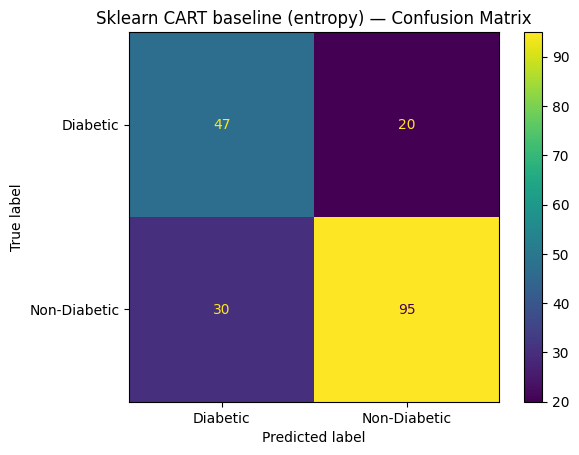

Dataset: Diabetes
Sklearn CART (entropy) accuracy: 0.7395833333333334


In [8]:
def sklearn_cart_baseline(df: pd.DataFrame, target: str, max_depth: int = 7):
    X = df.drop(columns=[target])
    y = df[target]

    cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", "passthrough", num_cols),
        ],
        remainder="drop"
    )
    model = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=max_depth)
    pipe = Pipeline([("pre", pre), ("model", model)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
    ConfusionMatrixDisplay(cm, display_labels=sorted(y.unique())).plot()
    plt.title("Sklearn CART baseline (entropy) — Confusion Matrix")
    plt.show()

    return pipe, acc, (X_train, X_test, y_train, y_test), (cat_cols, num_cols)

pipe0, acc_cart0, splits0, cols0 = sklearn_cart_baseline(df0, target0, max_depth=7)
print("Dataset:", name0)
print("Sklearn CART (entropy) accuracy:", acc_cart0)


,importance
Glucose,0.364255
BMI,0.218636
Age,0.131412
DiabetesPedigreeFunction,0.088172
Pregnancies,0.069069
BloodPressure,0.061748
Insulin,0.038545
SkinThickness,0.028163


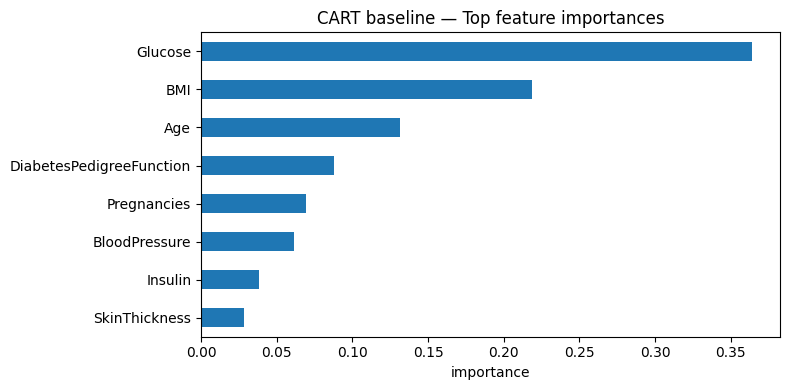

In [9]:
# Feature importances for the CART baseline
X_train, X_test, y_train, y_test = splits0
cat_cols, num_cols = cols0

pre = pipe0.named_steps["pre"]
model = pipe0.named_steps["model"]

# Get feature names after preprocessing (one-hot + numeric passthrough)
feature_names = []
if len(cat_cols) > 0:
    ohe = pre.named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out(cat_cols))
    feature_names.extend(cat_names)
feature_names.extend(num_cols)

importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
display(importances.head(20).to_frame("importance"))

plt.figure(figsize=(8,4))
importances.head(12).sort_values().plot(kind="barh")
plt.title("CART baseline — Top feature importances")
plt.xlabel("importance")
plt.tight_layout()
plt.show()



## آزمایش سوگیری high-cardinality (ویژگی شبیه ID)

یک دام کلاسیک: ویژگی‌ای که عملاً شناسه است (تقریباً یکتا برای هر ردیف) ممکن است برای **اطلاعات بهره** بسیار جذاب باشد،
چون داده را به گروه‌های کوچک و تقریباً خالص تقسیم می‌کند.

Gain Ratio این خردشدن را جریمه می‌کند.

در سل بعد:

1. از دیتاست اول یک کپی می‌گیریم،
2. یک ستون `__row_id__` با مقدارهای یکتا اضافه می‌کنیم،
3. بهترین ویژگی در ریشه را با دو معیار محاسبه می‌کنیم:
   - اطلاعاتِ بهره (ID3),
   - Gain Ratio (C4.5).

اغلب می‌بینید:
- IG به ویژگی شبیه ID علاقه‌مند می‌شود،
- Gain Ratio از آن دوری می‌کند.

سل بعد را اجرا کنید.


In [10]:
# High-cardinality bias experiment:
# Add an artificial unique identifier feature and compare what IG vs GainRatio prefers at the root.

def root_best_feature_information_gain(df: pd.DataFrame, target: str):
    y = df[target]
    X = df.drop(columns=[target])
    best = (None, -1.0)
    for col in X.columns:
        if pd.api.types.is_numeric_dtype(X[col]):
            # numeric: best IG over thresholds (same thresholds as earlier)
            tmp = pd.DataFrame({"x": X[col], "y": y}).dropna()
            if tmp["x"].nunique() <= 1:
                continue
            tmp = tmp.sort_values("x")
            uniq = np.unique(tmp["x"].values)
            thresholds = (uniq[:-1] + uniq[1:]) / 2.0
            best_ig = 0.0
            for t in thresholds:
                left_y = tmp.loc[tmp["x"] <= t, "y"]
                right_y = tmp.loc[tmp["x"] > t, "y"]
                ig = information_gain(tmp["y"], [left_y, right_y])
                best_ig = max(best_ig, ig)
            score = best_ig
        else:
            tmp = pd.DataFrame({"x": X[col], "y": y}).dropna()
            if tmp["x"].nunique() <= 1:
                continue
            groups = [tmp.loc[tmp["x"] == v, "y"] for v in tmp["x"].unique()]
            score = information_gain(tmp["y"], groups)
        if score > best[1]:
            best = (col, score)
    return best

work = df0.copy()
# ensure no missing
for c in work.columns:
    if c == target0:
        continue
    if pd.api.types.is_numeric_dtype(work[c]):
        work[c] = work[c].fillna(work[c].median())
    else:
        work[c] = work[c].fillna("__MISSING__")

work["__row_id__"] = [f"id_{i}" for i in range(len(work))]  # high-cardinality
best_ig = root_best_feature_information_gain(work, target0)
best_gr = find_best_split(work.drop(columns=[target0]), work[target0], infer_feature_types(work, target0))

print("Best root feature by Information Gain:", best_ig)
print("Best root feature by Gain Ratio:", (best_gr["feature"], best_gr["gain_ratio"]))


Best root feature by Information Gain: ('__row_id__', 0.9331343166407831)
Best root feature by Gain Ratio: ('Glucose', 0.19573164422208814)



## استخراج قوانین (IF–THEN)

در بسیاری از کاربردها قوانین قابل‌خواندن (برای ممیزی، حاکمیت مدل، و ارتباط با ذی‌نفعان) مهم هستند.

ما با پیمایش مسیرهای ریشه تا برگ قوانین را استخراج می‌کنیم و قوانین با پشتیبانی بیشتر را چاپ می‌کنیم.

سل بعد را اجرا کنید.


In [11]:
def extract_rules(node: Node, prefix=None):
    if prefix is None:
        prefix = []
    rules = []
    if node.is_leaf:
        cond = " AND ".join(prefix) if prefix else "TRUE"
        rules.append((cond, node.prediction, node.n_samples, node.class_counts))
        return rules
    if node.threshold is not None:
        rules += extract_rules(node.left, prefix=prefix + [f"{node.feature} <= {node.threshold:.5g}"])
        rules += extract_rules(node.right, prefix=prefix + [f"{node.feature} > {node.threshold:.5g}"])
    elif node.children:
        for v, ch in node.children.items():
            rules += extract_rules(ch, prefix=prefix + [f"{node.feature} == {repr(v)}"])
    else:
        rules.append((" AND ".join(prefix) if prefix else "TRUE", node.prediction, node.n_samples, node.class_counts))
    return rules

rules0 = extract_rules(tree0)
rules0_sorted = sorted(rules0, key=lambda x: x[2], reverse=True)
for cond, pred, n, counts in rules0_sorted[:15]:
    print(f"IF {cond} THEN class = {pred}  (support={n}, counts={counts})")


IF Glucose <= 166.5 AND BMI <= 52.6 AND Pregnancies <= 13.5 AND DiabetesPedigreeFunction <= 2.0345 AND BMI <= 48.1 AND Insulin <= 572.5 AND Glucose <= 154.5 THEN class = Non-Diabetic  (support=468, counts={'Non-Diabetic': 357, 'Diabetic': 111})
IF Glucose > 166.5 AND Insulin <= 643.5 AND BMI > 23.15 AND BMI <= 45.95 AND SkinThickness > 25.5 THEN class = Diabetic  (support=34, counts={'Diabetic': 34})
IF Glucose <= 166.5 AND BMI <= 52.6 AND Pregnancies <= 13.5 AND DiabetesPedigreeFunction <= 2.0345 AND BMI <= 48.1 AND Insulin <= 572.5 AND Glucose > 154.5 THEN class = Diabetic  (support=29, counts={'Diabetic': 19, 'Non-Diabetic': 10})
IF Glucose > 166.5 AND Insulin <= 643.5 AND BMI > 23.15 AND BMI <= 45.95 AND SkinThickness <= 25.5 AND DiabetesPedigreeFunction <= 1.337 AND DiabetesPedigreeFunction > 0.3135 THEN class = Diabetic  (support=15, counts={'Diabetic': 15})
IF Glucose <= 166.5 AND BMI <= 52.6 AND Pregnancies <= 13.5 AND DiabetesPedigreeFunction <= 2.0345 AND BMI > 48.1 THEN clas


## نمایش هرس (Reduced-Error Pruning)

C4.5 از هرس مبتنی بر خطا استفاده می‌کند، اما Reduced-Error یک نمایش مفهومی بسیار خوب است:

- درخت بزرگ‌تر بسازید (عمق بیشتر).
- از مجموعه اعتبارسنجی استفاده کنید.
- اگر دقت اعتبارسنجی بدتر نشود، زیر‌درخت را با برگ جایگزین کنید.

ما قبل/بعد از هرس را از نظر:

- عمق درخت،
- تعداد گره‌ها،
- دقت روی test

مقایسه می‌کنیم.

سل بعد را اجرا کنید.


In [12]:
def prune_reduced_error(node: Node, val_df: pd.DataFrame, target: str) -> Node:
    if node.is_leaf or val_df.empty:
        return node

    if node.threshold is not None:
        left_val = val_df[val_df[node.feature] <= node.threshold]
        right_val = val_df[val_df[node.feature] > node.threshold]
        node.left = prune_reduced_error(node.left, left_val, target)
        node.right = prune_reduced_error(node.right, right_val, target)
    elif node.children:
        new_children = {}
        for v, ch in node.children.items():
            sub_val = val_df[val_df[node.feature] == v]
            new_children[v] = prune_reduced_error(ch, sub_val, target)
        node.children = new_children

    Xv = val_df.drop(columns=[target])
    yv = val_df[target]
    pred_before = predict(node, Xv)
    acc_before = accuracy_score(yv, pred_before)

    leaf_pred = node.prediction
    acc_after = accuracy_score(yv, np.full(shape=len(yv), fill_value=leaf_pred))

    if acc_after >= acc_before:
        return Node(is_leaf=True, prediction=leaf_pred, n_samples=node.n_samples, class_counts=node.class_counts)
    return node

work0 = df0.copy()
for c in work0.columns:
    if c == target0:
        continue
    if pd.api.types.is_numeric_dtype(work0[c]):
        work0[c] = work0[c].fillna(work0[c].median())
    else:
        work0[c] = work0[c].fillna("__MISSING__")

train_df, temp_df = train_test_split(work0, test_size=0.35, random_state=42, stratify=work0[target0])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[target0])

tree_raw = build_tree(train_df, target=target0, max_depth=12, min_samples_split=5)
pred_raw = predict(tree_raw, test_df.drop(columns=[target0]))
acc_raw = accuracy_score(test_df[target0], pred_raw)

tree_pruned = prune_reduced_error(tree_raw, val_df, target0)
pred_pruned = predict(tree_pruned, test_df.drop(columns=[target0]))
acc_pruned = accuracy_score(test_df[target0], pred_pruned)

print("Before pruning: depth =", tree_depth(tree_raw), "nodes =", count_nodes(tree_raw), "test acc =", acc_raw)
print("After  pruning: depth =", tree_depth(tree_pruned), "nodes =", count_nodes(tree_pruned), "test acc =", acc_pruned)


Before pruning: depth = 13 nodes = 37 test acc = 0.6814814814814815
After  pruning: depth = 13 nodes = 37 test acc = 0.7185185185185186



## اعتبارسنجی متقاطع (Cross-validation)

تقسیم train/test می‌تواند پرنوسان باشد. برای تخمین پایدارتر، ۵-fold stratified CV را برای Baseline CART روی دیتاست اول اجرا می‌کنیم.

سل بعد را اجرا کنید.


In [13]:
# Cross-validation (CART baseline) on first dataset
X = df0.drop(columns=[target0])
y = df0[target0]

cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)
model = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=7)
pipe = Pipeline([("pre", pre), ("model", model)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
print("5-fold CV accuracy (CART entropy):", scores.mean(), "+/-", scores.std())


5-fold CV accuracy (CART entropy): 0.7134623546388252 +/- 0.03856482584277174



## نمایش بوستینگ (ایده‌ی نزدیک به C5.0)

بسیاری از پیاده‌سازی‌های C5.0 بوستینگ داخلی دارند: چند درخت آموزش دهید و ترکیب کنید.
ما ایده را با AdaBoost و درخت‌های کم‌عمق روی دیتاست **دوم** نشان می‌دهیم.

سل بعد را اجرا کنید.


Dataset: Glass | target: Type


C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost (stumps) accuracy: 0.5


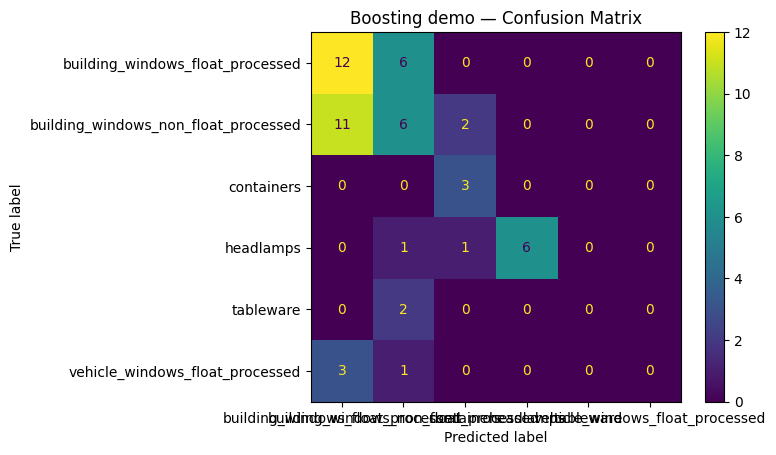

In [14]:
# "C5.0-style" idea demo: boosting small trees (C5.0 implements boosting natively).
# Here we use AdaBoost with decision stumps as an accessible proxy.

def boosting_demo(df: pd.DataFrame, target: str):
    X = df.drop(columns=[target])
    y = df[target]

    cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", "passthrough", num_cols),
        ],
        remainder="drop"
    )
    stump = DecisionTreeClassifier(criterion="entropy", max_depth=1, random_state=42)
    boost = AdaBoostClassifier(estimator=stump, n_estimators=200, learning_rate=0.5, random_state=42)

    pipe = Pipeline([("pre", pre), ("model", boost)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print("AdaBoost (stumps) accuracy:", acc)

    cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
    ConfusionMatrixDisplay(cm, display_labels=sorted(y.unique())).plot()
    plt.title("Boosting demo — Confusion Matrix")
    plt.show()

# Run on the second chosen dataset
name1 = CHOSEN[1][0]
df1 = datasets[name1]["df"]
target1 = datasets[name1]["target"]
print("Dataset:", name1, "| target:", target1)
boosting_demo(df1, target1)



---

# یادداشت‌های تکمیلی (آموزش مستقل)

این بخش عمداً طولانی‌تر نوشته شده تا نوت‌بوک خودکفا باشد.

## ۱) مقایسه مفهومی C4.5 / CART / ID3

- ID3:
  - معیار: اطلاعاتِ بهره
  - تمرکز کلاسیک روی ویژگی‌های طبقه‌ای
  - هرس/مدیریت عددی در نسخه‌های اولیه محدود

- CART:
  - معیار: جینی (پیش‌فرض) یا entropy
  - تقسیم‌های دودویی
  - مدیریت عددی قوی
  - گزینه‌های هرس/ریگولاریزیشن (مثل cost-complexity)

- C4.5:
  - معیار: Gain Ratio (با برخی هیوریستیک‌ها)
  - طبقه‌ای: تقسیم چندشاخه‌ای
  - عددی: تقسیم دودویی با آستانه
  - گمشده: ایده‌ی انتشار کسری (در نسخه‌های کامل)
  - هرس: هرس مبتنی بر خطا

- C5.0:
  - بهبودهای مهندسی (سرعت/حافظه)
  - استخراج قوانین بهتر در بسیاری از پیاده‌سازی‌ها
  - بوستینگ اختیاری
  - Winnowing اختیاری (انتخاب ویژگی)

## ۲) چرا درخت‌ها تا حدی نسبت به مقیاس حساس نیستند؟

تقسیم آستانه‌ای به ترتیب مقادیر وابسته است نه اندازه مطلق؛ بنابراین نرمال‌سازی برای درخت‌ها معمولاً حیاتی نیست.

## ۳) چرا درخت‌ها واریانس بالایی دارند؟

تغییر کوچک در داده می‌تواند تقسیم ریشه را عوض کند و ساختار زیر‌درخت‌ها را کاملاً تغییر دهد؛ به همین دلیل Bagging/Random Forest موثر است.

## ۴) راهبرد عملی برای گمشده‌ها

اگر انتشار کسری را پیاده‌سازی نکنید:
- عددی: میانه + (اختیاری) شاخص گمشده
- طبقه‌ای: تبدیل گمشده به یک دسته مجزا

ما همین کار را انجام داده‌ایم.

## ۵) ممیزی و نشت

قبل از اعتماد به مدل درختی:
- آیا ویژگی در زمان پیش‌بینی در دسترس است؟
- آیا برچسب را رمزگذاری می‌کند؟
- آیا پیش‌پردازش خارج از CV انجام شده و نشت ایجاد کرده است؟

## ۶) تمرین‌های تکمیلی

1. نسخه‌ای از جست‌وجوی آستانه بسازید که فقط نقاط تغییر کلاس را بررسی کند.
2. شاخص گمشده را به Baseline CART اضافه کنید و اثر را بسنجید.
3. روی Drug200، تفاوت تقسیم‌ها بین درخت سفارشی و CART(one-hot) را تحلیل کنید.
4. قوانین را استخراج کنید و به زبان سیاست انسانی بازنویسی نمایید.

پایان یادداشت‌های تکمیلی.



## تمرین‌ها و پاسخ‌های پیشنهادی

تمرین‌های بخش یادداشت‌های تکمیلی را انجام دهید و سپس سل کد پایانی را برای پاسخ‌های پیشنهادی (از جمله نمودار تغییر دقت با عمق) اجرا کنید.

یادآوری: در نوت‌بوک فارسی، کد و برچسب‌های نمودار انگلیسی باقی می‌مانند، اما متن توضیحی فارسی است.


Entropy(toy_y) = 0.954434002924965
IG = 0.954434002924965
GainRatio = 1.0
Dataset: Drug200
Custom gain-ratio tree acc: 0.98


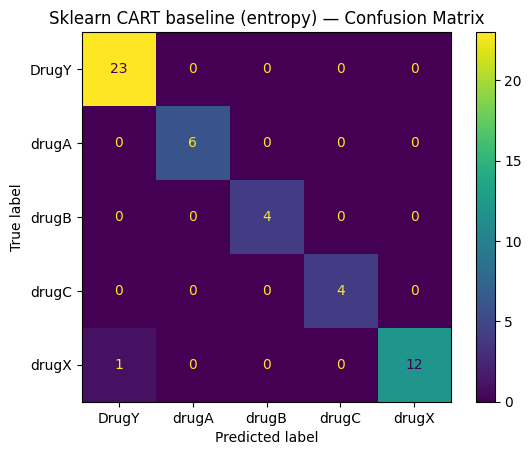

Sklearn CART (entropy)  acc: 0.98


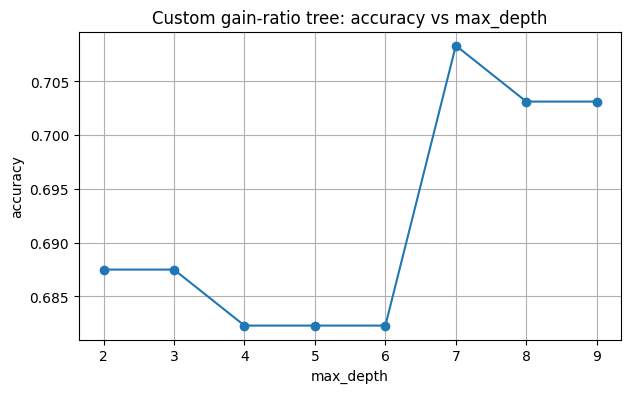

In [15]:
# Suggested answers / solution sketches for selected exercises

toy_y = pd.Series(["A","A","A","B","B","B","B","B"])
print("Entropy(toy_y) =", entropy(toy_y))

g1 = toy_y.iloc[:3]
g2 = toy_y.iloc[3:]
print("IG =", information_gain(toy_y, [g1, g2]))
print("GainRatio =", gain_ratio(toy_y, [g1, g2]))

# Compare custom vs CART on third dataset
name2 = CHOSEN[2][0]
df2 = datasets[name2]["df"]
target2 = datasets[name2]["target"]
tree2, train2, test2, acc2 = train_eval_custom_c45(df2, target2, max_depth=8)
print("Dataset:", name2)
print("Custom gain-ratio tree acc:", acc2)

pipe2, acc_cart2, _, _ = sklearn_cart_baseline(df2, target2, max_depth=8)
print("Sklearn CART (entropy)  acc:", acc_cart2)

# Small sweep for max_depth on the custom tree
depths = [2,3,4,5,6,7,8,9]
accs = []
for d in depths:
    _, _, _, a = train_eval_custom_c45(df0, target0, max_depth=d)
    accs.append(a)

plt.figure(figsize=(7,4))
plt.plot(depths, accs, marker="o")
plt.title("Custom gain-ratio tree: accuracy vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.grid(True)
plt.show()
